## Acknowledgement / Pengakuan
Code implementation and debugging assisted by AI.
Implementasi kode dan debugging dibantu oleh kecerdasan buatan (AI).

# Gravity Processing Workflow

Notebook ini memakai gravity raster yang **sudah sesuai AOI**: `grav_32.1.tif`.

Di notebook ini kamu bisa menghitung:
- Reproject DEM SRTM15+ ke grid gravity
- **Menghitung Terrain Correction (TC)** (metode spektral/FFT; Parker series truncation)
- Menghitung **BC, SBA, CBA**
- (Opsional) estimasi **ρ (Parasnis)**
- (Opsional) **Regional & Residual** (Butterworth)

> Catatan: “TC spektral” ini adalah pendekatan komputasional yang umum dipakai untuk efek gravitasi topografi secara cepat pada grid besar. 
> Dalam publikasi geofisika yang sangat ketat, banyak studi tetap memakai TC dari software geofisika (mis. Oasis montaj) sebagai pembanding/validasi.

---

## Sumber Data:
**DEM (SRTM15+)**: OpenTopography  
Tozer, B., Sandwell, D. T., Smith, W. H. F., Olson, C., Beale, J. R., & Wessel, P. (2019). *Global bathymetry and topography at 15 arc sec: SRTM15+*. Distributed by OpenTopography. https://doi.org/10.5069/G92R3PT9. Accessed 2025-09-03

**Gravity**: UCSD/Topex global gravity 1-min grid  
https://topex.ucsd.edu/pub/global_grav_1min/ (May 25, 2023)

---

## Persamaan utama
1) **Bouguer slab correction**  
\[
BC(\text{mGal}) \approx 0.04193\ \rho(\text{g/cm}^3)\ h(\text{m})
\]

2) **Simple Bouguer anomaly (SBA)**  
\[
SBA = FAA - BC
\]

3) **Complete Bouguer anomaly (CBA)**  
\[
CBA = FAA - BC + TC
\]

4) **Butterworth low-pass**  
\[
H_{LP}(k)=\frac{1}{\sqrt{1+(k/k_c)^{2n}}}
\]
Regional = LP(CBA); Residual = CBA − Regional

5) **Parasnis (opsional)**  
\[
BCTC = 0.04193\,h - \frac{TC}{\rho_0}
\]
\[
FAA \approx \rho\cdot BCTC + c
\]
Slope ≈ **ρ**.

---

## Output
Hasil/Output GeoTIFF akan ditulis ke folder `OUTDIR`:
- `TC_mGal_projected.tif` (TC di grid meter)
- `TC_mGal_on_gravity.tif` (TC pada grid gravity)
- `BC_mGal.tif`, `SBA_mGal.tif`, `CBA_mGal.tif`
- (opsional) `Regional_mGal.tif`, `Residual_mGal.tif`


In [1]:
# Mode:
# - "paper"  : treat all elevations (including negative bathymetry) with single rho (consistent w/ many simplified papers)
# - "marine" : experimental: treat bathymetry with density contrast (rho - rho_water). Use if AOI includes lots of sea.
TC_MODE = "paper"  # "paper" or "marine"

In [2]:
# =========================
# 0) Setup & paths
# =========================
# --- Jupyter interactive backend (optional) ---
# Needed ONLY if you set INTERACTIVE=True later (for plt.ginput).
# If this fails, run: pip install ipympl  (or conda install -c conda-forge ipympl)
try:
    get_ipython().run_line_magic('matplotlib', 'widget')
except Exception:
    try:
        get_ipython().run_line_magic('matplotlib', 'notebook')
    except Exception:
        pass

import os
import numpy as np
import pandas as pd
import rasterio
from rasterio.warp import reproject, Resampling, calculate_default_transform
from rasterio.transform import xy
from pyproj import CRS, Transformer
import matplotlib.pyplot as plt

# --- INPUTS (edit these paths) ---
GRAV_TIF = "input/grav_32.1.tif"      # gravity already clipped AOI (FAA, mGal)
DEM_TIF  = "input/SRTM15Plus.tif"     # SRTM15+ DEM (m)
# Optional external TC (if you already have it). If None, we compute TC in Jupyter.
TC_EXTERNAL_TIF = None

# --- OUTPUTS ---
OUTDIR = "output"
os.makedirs(OUTDIR, exist_ok=True)

# --- DENSITY / WATER ---
# rho: density of crustal rock (g/cm^3)
RHO_DEFAULT = 2.67
# water density (g/cm^3) used only if you enable MARINE_MODE below
RHO_WATER = 1.03

# --- Parasnis (optional) ---
ESTIMATE_RHO = True
SAMPLE_STEP = 6
RHO0_FOR_TC = 2.67

# --- TC computation controls (spectral/FFT) ---
COMPUTE_TC = True              # if True, compute TC (unless TC_EXTERNAL_TIF provided)
TC_TERMS = 3                   # Parker series truncation terms (2 or 3 recommended)
TC_PROJECTED_PX_M = 2000        # pixel size for projected TC grid (m) (1000–3000 typical)
TC_PAD_FACTOR = 0.35            # padding fraction to reduce wrap-around (0.2–0.5)
APODIZE = True                  # apply cosine taper before FFT


# --- Filtering (regional/residual) ---
DO_FILTER   = True
FILTER_PX_M = 2000
CUTOFF_KM   = 120
ORDER_N     = 4

# --- Land-only (remove sea) masking ---
# NOTE: We recommend keeping sea during FFT/filtering for numerical stability,
# then masking sea in the FINAL outputs (maps/statistics).
SEA_LEVEL_M = 0.0              # sea is usually DEM < 0 m (bathymetry)
EXPORT_LANDONLY = True         # also write *_landonly.tif outputs
MASK_SEA_FOR_PLOTS = True      # show land-only arrays in plots
NODATA_OUT = -9999.0           # nodata value written to GeoTIFF (float32)

print("Inputs:", GRAV_TIF, DEM_TIF)
print("OUTDIR:", OUTDIR)

Inputs: input/grav_32.1.tif input/SRTM15Plus.tif
OUTDIR: output


Gravity CRS: EPSG:4326
DEM CRS    : EPSG:4326
Gravity bounds: BoundingBox(left=118.616666667, bottom=-6.299999999999999, right=126.15, top=2.333333333)
Gravity shape: (518, 452)
Gravity nodata: -1000000000.0


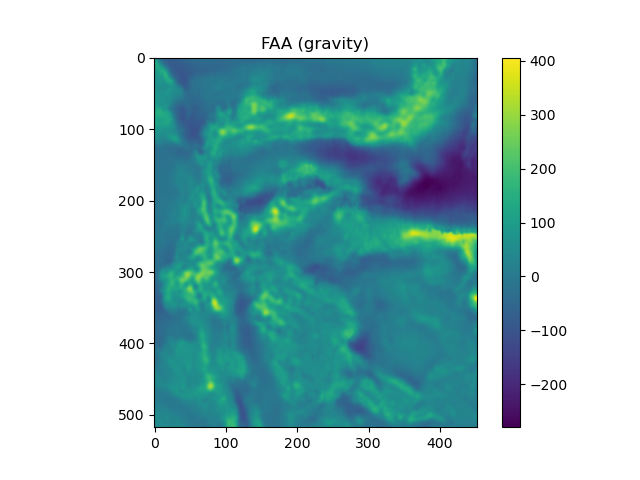

In [3]:
# =========================
# 1) Read rasters + quick checks
# =========================
def assume_crs_if_missing(ds, epsg=4326, label="raster"):
    if ds.crs is None:
        print(f"[WARN] {label} has no CRS. Assuming EPSG:{epsg}")
        return CRS.from_epsg(epsg)
    return ds.crs

with rasterio.open(GRAV_TIF) as gds, rasterio.open(DEM_TIF) as dds:
    grav_crs = assume_crs_if_missing(gds, 4326, "gravity")
    dem_crs  = assume_crs_if_missing(dds, 4326, "dem")

    print("Gravity CRS:", grav_crs)
    print("DEM CRS    :", dem_crs)
    print("Gravity bounds:", gds.bounds)
    print("Gravity shape:", (gds.height, gds.width))
    print("Gravity nodata:", gds.nodata)

    faa = gds.read(1).astype("float32")
    if gds.nodata is not None:
        faa = np.where(faa == gds.nodata, np.nan, faa)

    plt.figure()
    plt.title("FAA (gravity)")
    plt.imshow(faa)
    plt.colorbar()
    plt.show()

DEM on gravity grid: (518, 452) TC on gravity grid: (518, 452)


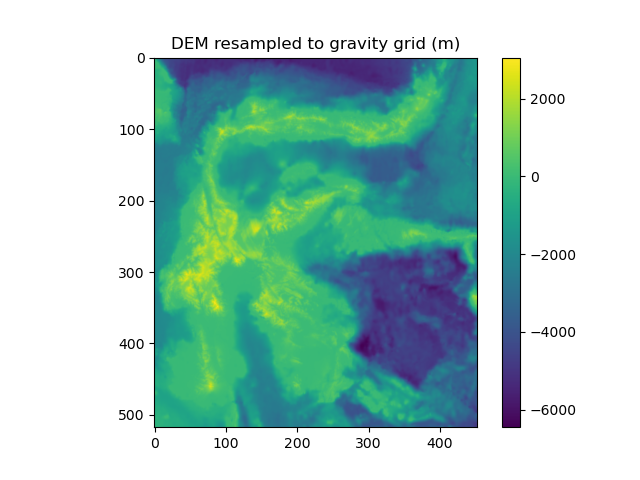

In [4]:
# =========================
# 2) Reproject DEM to gravity grid (and external TC if provided)
# =========================
def reproject_to_match(src_ds, src_arr, dst_ds, resampling=Resampling.bilinear):
    dst = np.empty((dst_ds.height, dst_ds.width), dtype=np.float32)
    reproject(
        source=src_arr,
        destination=dst,
        src_transform=src_ds.transform,
        src_crs=src_ds.crs,
        dst_transform=dst_ds.transform,
        dst_crs=dst_ds.crs,
        resampling=resampling
    )
    return dst

with rasterio.open(GRAV_TIF) as gds, rasterio.open(DEM_TIF) as dds:
    faa = gds.read(1).astype("float32")
    if gds.nodata is not None:
        faa = np.where(faa == gds.nodata, np.nan, faa)

    dem_src = dds.read(1).astype("float32")
    if dds.nodata is not None:
        dem_src = np.where(dem_src == dds.nodata, np.nan, dem_src)

    dem_on_g = reproject_to_match(dds, dem_src, gds, Resampling.bilinear)

    if TC_EXTERNAL_TIF:
        with rasterio.open(TC_EXTERNAL_TIF) as tcds:
            tc_src = tcds.read(1).astype("float32")
            if tcds.nodata is not None:
                tc_src = np.where(tc_src == tcds.nodata, np.nan, tc_src)
            tc_on_g = reproject_to_match(tcds, tc_src, gds, Resampling.bilinear)
    else:
        tc_on_g = np.zeros_like(dem_on_g, dtype=np.float32)

    print("DEM on gravity grid:", dem_on_g.shape, "TC on gravity grid:", tc_on_g.shape)

    plt.figure()
    plt.title("DEM resampled to gravity grid (m)")
    plt.imshow(dem_on_g)
    plt.colorbar()
    plt.show()

[WRITE] output\TC_mGal_projected.tif


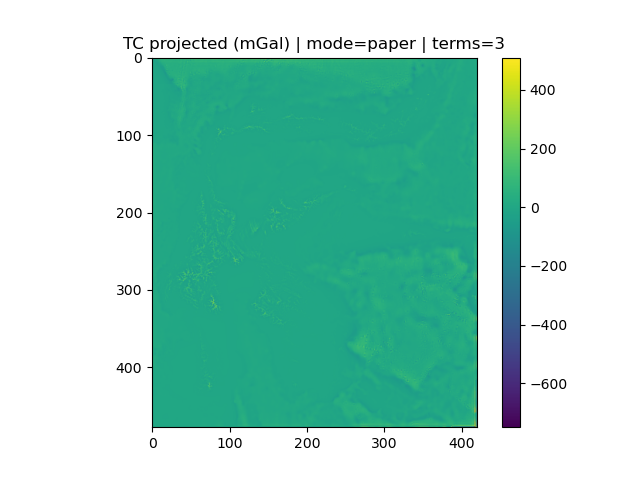

[WRITE] output\TC_mGal_on_gravity.tif


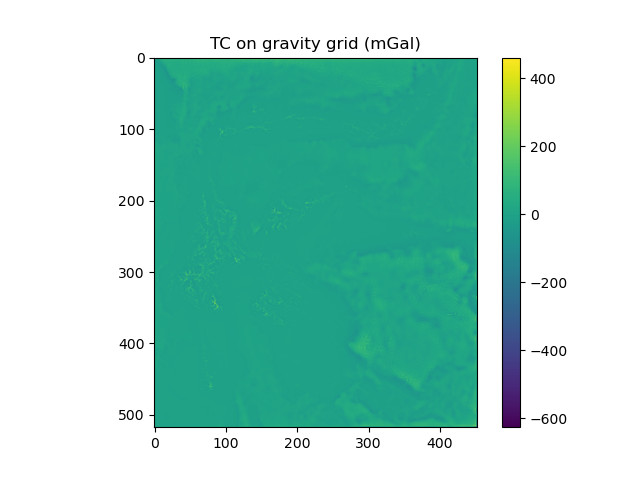

In [5]:
# =========================
# 3) Compute Terrain Correction (TC) in Jupyter (Spectral / FFT)
# =========================
# Prinsip:
# - Hitung efek gravitasi topografi g_topo dari DEM menggunakan pendekatan spektral (Parker series truncation).
# - Terrain correction: TC = g_topo - (2πGρh)  (yakni g_topo minus Bouguer slab term).
#
# Ini menghasilkan TC pada grid meter (projected), lalu direproject kembali ke grid gravity.
#
# Catatan:
# - TC paling sensitif pada topografi dekat (near-field). Pendekatan spektral efisien untuk AOI besar.
# - Untuk AOI yang termasuk laut, mode "marine" bisa dicoba (eksperimental).
#
import math

G_SI = 6.67430e-11  # m^3 kg^-1 s^-2
SI_to_mGal = 1e5    # 1 m/s^2 = 1e5 mGal

def laea_centered_crs(lon0, lat0):
    proj4 = f"+proj=laea +lat_0={lat0} +lon_0={lon0} +datum=WGS84 +units=m +no_defs"
    return CRS.from_proj4(proj4)

def cosine_taper_2d(ny, nx, frac=0.08):
    """2D cosine taper window to reduce edge discontinuities for FFT."""
    frac = float(frac)
    wy = np.ones(ny, dtype=float)
    wx = np.ones(nx, dtype=float)
    ty = max(1, int(frac * ny))
    tx = max(1, int(frac * nx))
    # y taper
    y = np.linspace(0, math.pi/2, ty)
    wy[:ty] = np.sin(y)**2
    wy[-ty:] = wy[:ty][::-1]
    # x taper
    x = np.linspace(0, math.pi/2, tx)
    wx[:tx] = np.sin(x)**2
    wx[-tx:] = wx[:tx][::-1]
    return np.outer(wy, wx)

def parker_gravity_topo_mgal(h_m, dx_m, dy_m, rho_gcm3, n_terms=3):
    """Compute gravity effect (mGal) of topography using truncated Parker series.

    h_m: 2D topography (m), positive up; may include negative.
    dx_m, dy_m: pixel size (m)
    rho_gcm3: density (g/cm^3)
    n_terms: number of terms (>=1). Using 3 gives better terrain effect than 1.

    Returns: g_topo_mGal (2D)
    """
    rho = float(rho_gcm3) * 1000.0  # kg/m^3
    ny, nx = h_m.shape

    fx = np.fft.fftfreq(nx, d=dx_m)  # cycles/m
    fy = np.fft.fftfreq(ny, d=dy_m)  # cycles/m
    k_cyc = np.sqrt(np.meshgrid(fx, fy)[0]**2 + np.meshgrid(fx, fy)[1]**2)
    k_rad = 2*np.pi*k_cyc  # rad/m

    # Sum in frequency domain:
    # g(k) = 2πGΔρ * Σ_{n=1..N} (k^{n-1}/n!) * F[h^n]
    # For n=1 term -> 2πGΔρ * F[h] which in space is just slab (first-order).
    gk = np.zeros((ny, nx), dtype=np.complex128)
    for n in range(1, int(n_terms)+1):
        hn = h_m**n
        Fhn = np.fft.fft2(hn)
        coeff = (k_rad**(n-1)) / math.factorial(n)
        gk += coeff * Fhn

    gk *= (2*np.pi*G_SI*rho)
    g_si = np.real(np.fft.ifft2(gk))  # m/s^2
    return g_si * SI_to_mGal

def compute_tc_from_dem_projected(dem_proj_m, dx_m, dy_m, rho, rho_water, mode="paper", n_terms=3):
    """Return TC_mGal on projected grid."""
    h = dem_proj_m.astype(float)

    # Fill NaN with 0 to avoid FFT artifacts (0 m reference)
    nanmask = ~np.isfinite(h)
    h2 = h.copy()
    h2[nanmask] = 0.0

    if mode == "paper":
        g_topo = parker_gravity_topo_mgal(h2, dx_m, dy_m, rho_gcm3=rho, n_terms=n_terms)
        slab = 0.04193 * float(rho) * h2
        tc = g_topo - slab
        tc[nanmask] = np.nan
        return tc

    if mode == "marine":
        # Experimental: split land (+) and bathymetry (-) with different density contrasts.
        # Land: contrast rho (rock-air)
        h_land = np.clip(h2, 0, None)
        g_land = parker_gravity_topo_mgal(h_land, dx_m, dy_m, rho_gcm3=rho, n_terms=n_terms)
        slab_land = 0.04193 * float(rho) * h_land

        # Bathymetry: treat as negative relief with reduced contrast (rho - rho_water)
        # Here we keep h_neg negative values; use contrast (rho - rho_water).
        contrast = max(0.0, float(rho) - float(rho_water))
        h_bathy = np.clip(h2, None, 0)  # negative
        g_bathy = parker_gravity_topo_mgal(h_bathy, dx_m, dy_m, rho_gcm3=contrast, n_terms=n_terms)
        slab_bathy = 0.04193 * float(contrast) * h_bathy

        g_topo = g_land + g_bathy
        slab = slab_land + slab_bathy
        tc = g_topo - slab
        tc[nanmask] = np.nan
        return tc

    raise ValueError("mode must be 'paper' or 'marine'")

with rasterio.open(GRAV_TIF) as gds, rasterio.open(DEM_TIF) as dds:
    # If external TC provided, skip compute
    if (TC_EXTERNAL_TIF is not None) or (not COMPUTE_TC):
        print("[INFO] Skip TC compute (using external TC or COMPUTE_TC=False)")
    else:
        # center lon/lat for projection
        cx = (gds.bounds.left + gds.bounds.right) / 2.0
        cy = (gds.bounds.bottom + gds.bounds.top) / 2.0
        to_wgs = Transformer.from_crs(gds.crs, "EPSG:4326", always_xy=True)
        lon0, lat0 = to_wgs.transform(cx, cy)
        proj_crs = laea_centered_crs(lon0, lat0)

        px = float(TC_PROJECTED_PX_M)
        dst_transform, dst_w, dst_h = calculate_default_transform(
            gds.crs, proj_crs, gds.width, gds.height, *gds.bounds, resolution=px
        )

        # Reproject DEM to projected grid
        dem_src = dds.read(1).astype("float32")
        if dds.nodata is not None:
            dem_src = np.where(dem_src == dds.nodata, np.nan, dem_src)

        dem_proj = np.empty((dst_h, dst_w), dtype=np.float32)
        reproject(
            source=dem_src,
            destination=dem_proj,
            src_transform=dds.transform,
            src_crs=dds.crs,
            dst_transform=dst_transform,
            dst_crs=proj_crs,
            resampling=Resampling.bilinear
        )

        # Padding to reduce wrap-around
        pad_y = int(TC_PAD_FACTOR * dst_h)
        pad_x = int(TC_PAD_FACTOR * dst_w)
        dem_pad = np.pad(dem_proj, ((pad_y, pad_y), (pad_x, pad_x)), mode="constant", constant_values=0.0)

        if APODIZE:
            win = cosine_taper_2d(dem_pad.shape[0], dem_pad.shape[1], frac=0.08)
            dem_pad = dem_pad * win

        # Use rho (estimated if you already ran Parasnis cell; otherwise default)
        # We try to read RHO_USED if it exists; else fall back.
        rho_here = float(globals().get("RHO_USED", RHO_DEFAULT))

        tc_pad = compute_tc_from_dem_projected(
            dem_pad, dx_m=px, dy_m=px,
            rho=rho_here, rho_water=float(RHO_WATER),
            mode=str(TC_MODE), n_terms=int(TC_TERMS)
        )

        # Unpad back
        tc_proj = tc_pad[pad_y:-pad_y, pad_x:-pad_x].astype(np.float32)

        # Save projected TC
        tc_proj_path = os.path.join(OUTDIR, "TC_mGal_projected.tif")
        profile = gds.profile.copy()
        profile.update({
            "crs": proj_crs,
            "transform": dst_transform,
            "width": dst_w,
            "height": dst_h,
            "dtype": rasterio.float32,
            "count": 1,
            "compress": "deflate"
        })
        with rasterio.open(tc_proj_path, "w", **profile) as out:
            out.write(tc_proj, 1)
        print("[WRITE]", tc_proj_path)

        # Visualize projected TC
        plt.figure()
        plt.title(f"TC projected (mGal) | mode={TC_MODE} | terms={TC_TERMS}")
        plt.imshow(tc_proj)
        plt.colorbar()
        plt.show()

        # Warp projected TC back to gravity grid
        tc_on_g = np.empty((gds.height, gds.width), dtype=np.float32)
        reproject(
            source=tc_proj,
            destination=tc_on_g,
            src_transform=dst_transform,
            src_crs=proj_crs,
            dst_transform=gds.transform,
            dst_crs=gds.crs,
            resampling=Resampling.bilinear
        )

        tc_on_g_path = os.path.join(OUTDIR, "TC_mGal_on_gravity.tif")
        profile_g = gds.profile.copy()
        profile_g.update(dtype=rasterio.float32, count=1, compress="deflate")
        with rasterio.open(tc_on_g_path, "w", **profile_g) as out:
            out.write(tc_on_g.astype(np.float32), 1)
        print("[WRITE]", tc_on_g_path)

        plt.figure()
        plt.title("TC on gravity grid (mGal)")
        plt.imshow(tc_on_g)
        plt.colorbar()
        plt.show()

        # Store globally for downstream cells
        globals()["TC_ON_G"] = tc_on_g
        globals()["TC_ON_G_PATH"] = tc_on_g_path
        globals()["TC_PROJECTED_PATH"] = tc_proj_path

[Parasnis] rho = 1.8756 g/cm^3 | intercept = 66.8789 mGal | R2 = 0.3042 | n = 1649
[CSV] saved: output\parasnis_samples.csv
[CSV] saved: output\parasnis_summary.csv


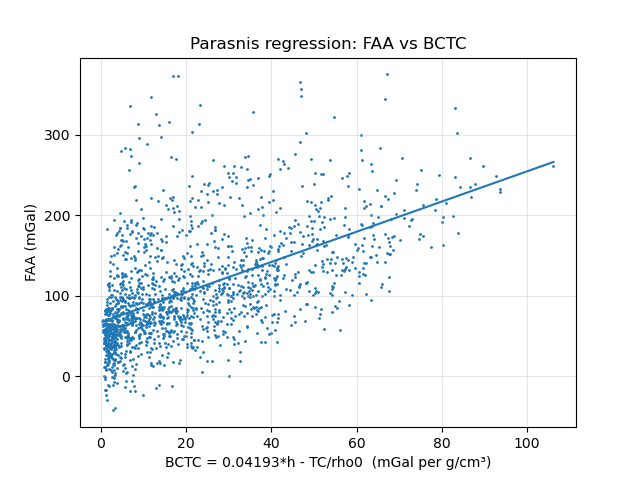

RHO_USED (g/cm^3) = 1.8755794320110808


In [6]:
# =========================
# 4) Parasnis density estimate (optional) using TC (if available)
#    + CSV outputs (samples + summary) with coordinates (x/y + lon/lat)
# =========================
# Outputs written to OUTDIR:
# - parasnis_samples.csv : point samples (x_map, y_map, lon/lat, FAA, h, TC, BCTC)
# - parasnis_summary.csv : rho, intercept, R2, n, parameters
#
# Units:
# - FAA: mGal
# - h: meters
# - TC: mGal
# - BCTC = 0.04193*h - TC/rho0 : (mGal per g/cm^3)
# - rho: g/cm^3

PARASNIS_PREFIX = "parasnis"
PARASNIS_MAX_POINTS_SAVE = 200_000
SAVE_PARASNIS_CSV = True
EXPORT_LONLAT = True

def online_linreg(x, y):
    m = np.isfinite(x) & np.isfinite(y)
    x = x[m].astype(float)
    y = y[m].astype(float)
    n = x.size
    if n < 2:
        raise ValueError("Not enough points for regression.")
    sx, sy = x.sum(), y.sum()
    sxx = (x*x).sum()
    sxy = (x*y).sum()
    syy = (y*y).sum()
    denom = n*sxx - sx*sx
    a = (n*sxy - sx*sy) / denom  # slope
    b = (sy - a*sx) / n          # intercept
    ybar = sy/n
    sst = syy - n*(ybar*ybar)
    sse = syy + (a*a)*sxx + n*(b*b) - 2*a*sxy - 2*b*sy + 2*a*b*sx
    r2 = 1 - sse/sst if sst > 0 else np.nan
    return a, b, r2, n

with rasterio.open(GRAV_TIF) as gds, rasterio.open(DEM_TIF) as dds:
    faa = gds.read(1).astype("float32")
    if gds.nodata is not None:
        faa = np.where(faa == gds.nodata, np.nan, faa)

    dem_src = dds.read(1).astype("float32")
    if dds.nodata is not None:
        dem_src = np.where(dem_src == dds.nodata, np.nan, dem_src)
    dem_on_g = reproject_to_match(dds, dem_src, gds, Resampling.bilinear)

    # land/sea mask (sea removed for Parasnis)
    land_mask_g = np.isfinite(dem_on_g) & (dem_on_g >= float(SEA_LEVEL_M))

    # Use TC in this priority:
    # 1) external TC raster (already reprojected earlier)
    # 2) computed TC (TC_ON_G global)
    # 3) zeros
    if TC_EXTERNAL_TIF:
        with rasterio.open(TC_EXTERNAL_TIF) as tcds:
            tc_src = tcds.read(1).astype("float32")
            if tcds.nodata is not None:
                tc_src = np.where(tc_src == tcds.nodata, np.nan, tc_src)
            tc_on_g = reproject_to_match(tcds, tc_src, gds, Resampling.bilinear)
    else:
        tc_on_g = globals().get("TC_ON_G", np.zeros_like(dem_on_g, dtype=np.float32))

    if ESTIMATE_RHO:
        step = max(1, int(SAMPLE_STEP))
        h  = dem_on_g[::step, ::step]        # m
        tc = tc_on_g[::step, ::step]         # mGal
        y  = faa[::step, ::step]             # mGal
        lm = land_mask_g[::step, ::step]     # bool

        # BCTC = 0.04193*h - TC/rho0  (mGal per g/cm^3)
        x = 0.04193*h - (tc/float(RHO0_FOR_TC) if np.any(np.isfinite(tc)) else 0.0)

        m = lm & np.isfinite(x) & np.isfinite(y)
        x_use = x[m].astype(float)
        y_use = y[m].astype(float)

        rho_est, intercept, r2, n = online_linreg(x_use, y_use)
        print(f"[Parasnis] rho = {rho_est:.4f} g/cm^3 | intercept = {intercept:.4f} mGal | R2 = {r2:.4f} | n = {n}")

        # ---------------- CSV export ----------------
        if SAVE_PARASNIS_CSV:
            rr_s, cc_s = np.where(m)   # indices on sampled grid
            rr_full = rr_s * step
            cc_full = cc_s * step

            if x_use.size > PARASNIS_MAX_POINTS_SAVE:
                idx = np.random.choice(x_use.size, PARASNIS_MAX_POINTS_SAVE, replace=False)
                x_s  = x_use[idx]
                y_s  = y_use[idx]
                h_s  = h[m].astype(float)[idx]
                tc_s = tc[m].astype(float)[idx]
                rr_pick = rr_full[idx]
                cc_pick = cc_full[idx]
            else:
                x_s  = x_use
                y_s  = y_use
                h_s  = h[m].astype(float)
                tc_s = tc[m].astype(float)
                rr_pick = rr_full
                cc_pick = cc_full

            # x/y map coords in gravity CRS
            x_map, y_map = xy(gds.transform, rr_pick, cc_pick, offset="center")
            x_map = np.asarray(x_map, dtype=float)
            y_map = np.asarray(y_map, dtype=float)

            lon = np.full_like(x_map, np.nan, dtype=float)
            lat = np.full_like(y_map, np.nan, dtype=float)
            if EXPORT_LONLAT and (gds.crs is not None):
                try:
                    tf = Transformer.from_crs(gds.crs, "EPSG:4326", always_xy=True)
                    lon, lat = tf.transform(x_map, y_map)
                    lon = np.asarray(lon, dtype=float)
                    lat = np.asarray(lat, dtype=float)
                except Exception as e:
                    print("[WARN] Failed to transform to lon/lat:", e)

            samples_csv = os.path.join(OUTDIR, f"{PARASNIS_PREFIX}_samples.csv")
            summary_csv = os.path.join(OUTDIR, f"{PARASNIS_PREFIX}_summary.csv")

            df_samples = pd.DataFrame({
                "x_map": x_map,
                "y_map": y_map,
                "lon_deg": lon,
                "lat_deg": lat,
                "FAA_mGal": y_s,
                "h_m": h_s,
                "TC_mGal": tc_s,
                "BCTC_mGal_per_gcm3": x_s,
            })
            df_samples.to_csv(samples_csv, index=False)

            df_summary = pd.DataFrame([{
                "rho_gcm3": float(rho_est),
                "intercept_mGal": float(intercept),
                "r2": float(r2),
                "n_points_used": int(n),
                "sample_step": int(step),
                "sea_level_m": float(SEA_LEVEL_M),
                "rho0_for_tc_gcm3": float(RHO0_FOR_TC),
                "max_points_saved": int(PARASNIS_MAX_POINTS_SAVE),
                "grav_tif": os.path.basename(GRAV_TIF),
                "dem_tif": os.path.basename(DEM_TIF),
                "tc_external_tif": os.path.basename(TC_EXTERNAL_TIF) if TC_EXTERNAL_TIF else "",
                "grav_crs": str(gds.crs) if gds.crs else "",
            }])
            df_summary.to_csv(summary_csv, index=False)

            print("[CSV] saved:", samples_csv)
            print("[CSV] saved:", summary_csv)

        # Plot (downsample for speed)
        xs = x_use
        ys = y_use
        if xs.size > 150000:
            idx = np.random.choice(xs.size, 150000, replace=False)
            xs = xs[idx]; ys = ys[idx]

        plt.figure()
        plt.title("Parasnis regression: FAA vs BCTC")
        plt.scatter(xs, ys, s=1)
        xline = np.array([np.nanmin(xs), np.nanmax(xs)])
        yline = rho_est*xline + intercept
        plt.plot(xline, yline)
        plt.xlabel("BCTC = 0.04193*h - TC/rho0  (mGal per g/cm³)")
        plt.ylabel("FAA (mGal)")
        plt.grid(True, alpha=0.3)
        plt.show()

        RHO_USED = float(rho_est)
    else:
        RHO_USED = float(RHO_DEFAULT)
        print("[INFO] Using default rho:", RHO_USED)

print("RHO_USED (g/cm^3) =", RHO_USED)


Land-only written:
 - output\TC_mGal_landonly.tif
 - output\BC_mGal_landonly.tif
 - output\SBA_mGal_landonly.tif
 - output\CBA_mGal_landonly.tif
Written:
 - output\TC_mGal_on_gravity.tif
 - output\BC_mGal.tif
 - output\SBA_mGal.tif
 - output\CBA_mGal.tif


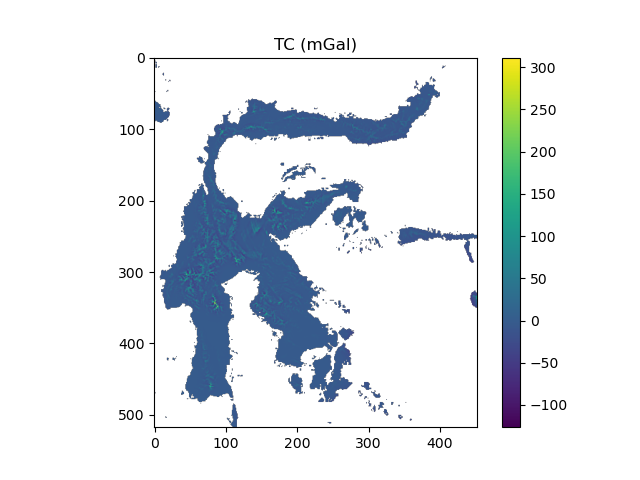

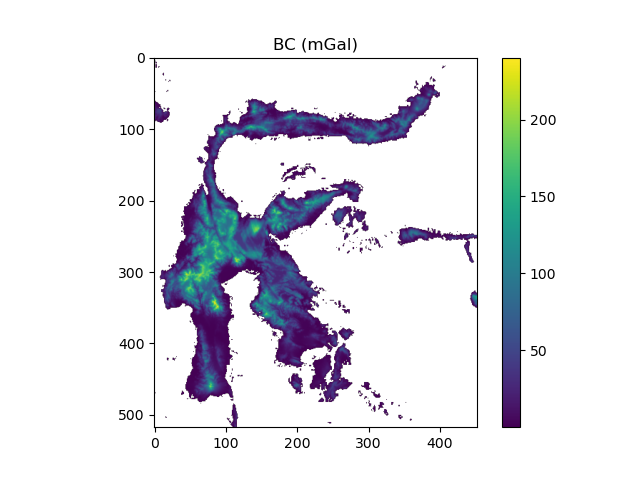

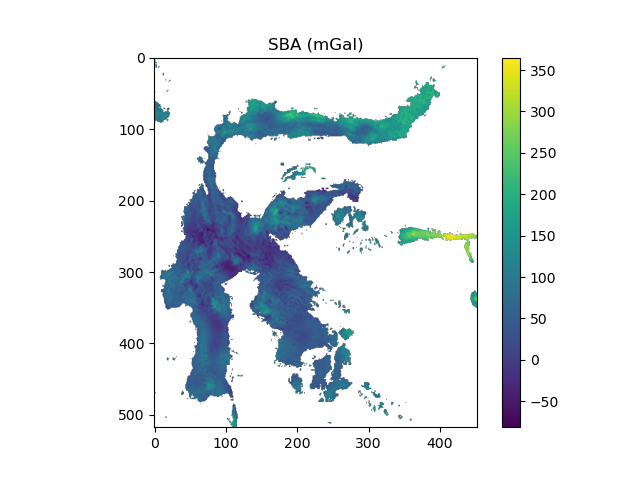

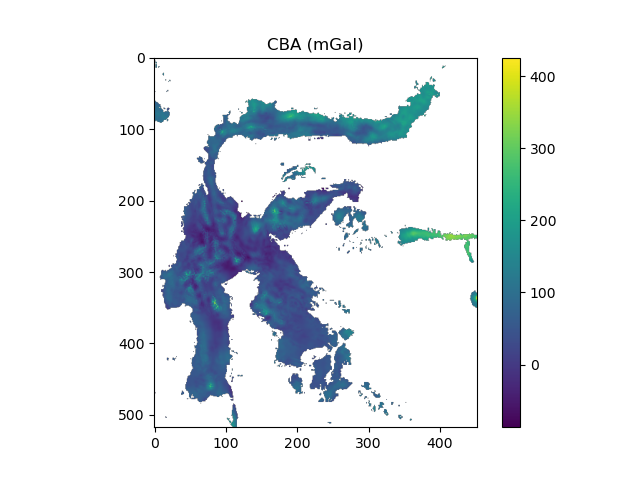

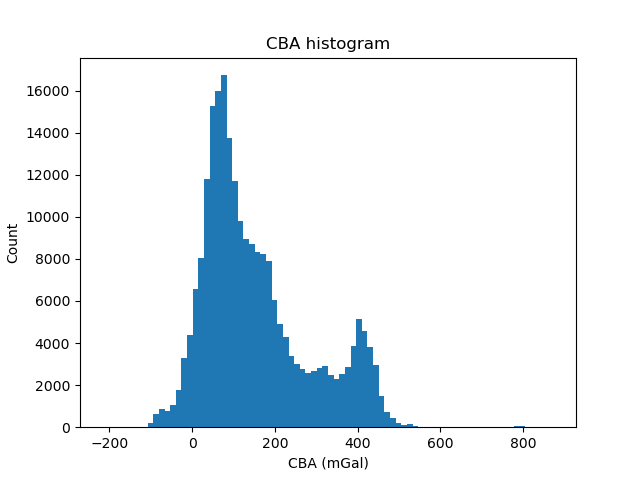

In [7]:
# =========================
# 5) Compute BC/SBA/CBA (including TC) + write outputs + visualize
# =========================
def write_tif_like(ref_ds, out_path, arr):
    profile = ref_ds.profile.copy()
    profile.update(dtype=rasterio.float32, count=1, compress="deflate")
    with rasterio.open(out_path, "w", **profile) as out:
        out.write(arr.astype(np.float32), 1)

with rasterio.open(GRAV_TIF) as gds, rasterio.open(DEM_TIF) as dds:
    faa = gds.read(1).astype("float32")
    if gds.nodata is not None:
        faa = np.where(faa == gds.nodata, np.nan, faa)

    dem_src = dds.read(1).astype("float32")
    if dds.nodata is not None:
        dem_src = np.where(dem_src == dds.nodata, np.nan, dem_src)
    dem_on_g = reproject_to_match(dds, dem_src, gds, Resampling.bilinear)

    # Land mask (remove sea): DEM >= SEA_LEVEL_M
    land_mask_g = np.isfinite(dem_on_g) & (dem_on_g >= float(SEA_LEVEL_M))

    if TC_EXTERNAL_TIF:
        with rasterio.open(TC_EXTERNAL_TIF) as tcds:
            tc_src = tcds.read(1).astype("float32")
            if tcds.nodata is not None:
                tc_src = np.where(tc_src == tcds.nodata, np.nan, tc_src)
            tc_on_g = reproject_to_match(tcds, tc_src, gds, Resampling.bilinear)
    else:
        tc_on_g = globals().get("TC_ON_G", np.zeros_like(dem_on_g, dtype=np.float32))

    # --- Equations ---
    bc  = 0.04193 * float(RHO_USED) * dem_on_g
    sba = faa - bc
    cba = faa - bc + tc_on_g

    # Write
    bc_path  = os.path.join(OUTDIR, "BC_mGal.tif")
    sba_path = os.path.join(OUTDIR, "SBA_mGal.tif")
    cba_path = os.path.join(OUTDIR, "CBA_mGal.tif")
    tc_path  = os.path.join(OUTDIR, "TC_mGal_on_gravity.tif")

    write_tif_like(gds, bc_path, bc)
    write_tif_like(gds, sba_path, sba)
    write_tif_like(gds, cba_path, cba)
    # also save tc_on_g if not already saved
    write_tif_like(gds, tc_path, tc_on_g)

    # --- Land-only (sea removed) outputs ---
    if EXPORT_LANDONLY:
        tc_land  = np.where(land_mask_g, tc_on_g, np.nan)
        bc_land  = np.where(land_mask_g, bc,      np.nan)
        sba_land = np.where(land_mask_g, sba,     np.nan)
        cba_land = np.where(land_mask_g, cba,     np.nan)

        tc_land_path  = os.path.join(OUTDIR, "TC_mGal_landonly.tif")
        bc_land_path  = os.path.join(OUTDIR, "BC_mGal_landonly.tif")
        sba_land_path = os.path.join(OUTDIR, "SBA_mGal_landonly.tif")
        cba_land_path = os.path.join(OUTDIR, "CBA_mGal_landonly.tif")

        write_tif_like(gds, tc_land_path,  tc_land)
        write_tif_like(gds, bc_land_path,  bc_land)
        write_tif_like(gds, sba_land_path, sba_land)
        write_tif_like(gds, cba_land_path, cba_land)

        print("Land-only written:")
        print(" -", tc_land_path)
        print(" -", bc_land_path)
        print(" -", sba_land_path)
        print(" -", cba_land_path)

    print("Written:")
    print(" -", tc_path)
    print(" -", bc_path)
    print(" -", sba_path)
    print(" -", cba_path)

    # For visualization: optionally mask sea
    if MASK_SEA_FOR_PLOTS:
        tc_plot  = np.where(land_mask_g, tc_on_g, np.nan)
        bc_plot  = np.where(land_mask_g, bc,      np.nan)
        sba_plot = np.where(land_mask_g, sba,     np.nan)
        cba_plot = np.where(land_mask_g, cba,     np.nan)
    else:
        tc_plot, bc_plot, sba_plot, cba_plot = tc_on_g, bc, sba, cba

    for name, arr in [("TC (mGal)", tc_plot), ("BC (mGal)", bc_plot), ("SBA (mGal)", sba_plot), ("CBA (mGal)", cba_plot)]:
        plt.figure()
        plt.title(name)
        plt.imshow(arr)
        plt.colorbar()
        plt.show()

    # Histogram
    plt.figure()
    plt.title("CBA histogram")
    vals = cba[np.isfinite(cba)]
    plt.hist(vals, bins=80)
    plt.xlabel("CBA (mGal)")
    plt.ylabel("Count")
    plt.show()

[WRITE] output\CBA_projected_mGal.tif
[WRITE] output\Regional_mGal.tif
[WRITE] output\Residual_mGal.tif
[WRITE] output\CBA_projected_mGal_landonly.tif
[WRITE] output\Regional_mGal_landonly.tif
[WRITE] output\Residual_mGal_landonly.tif


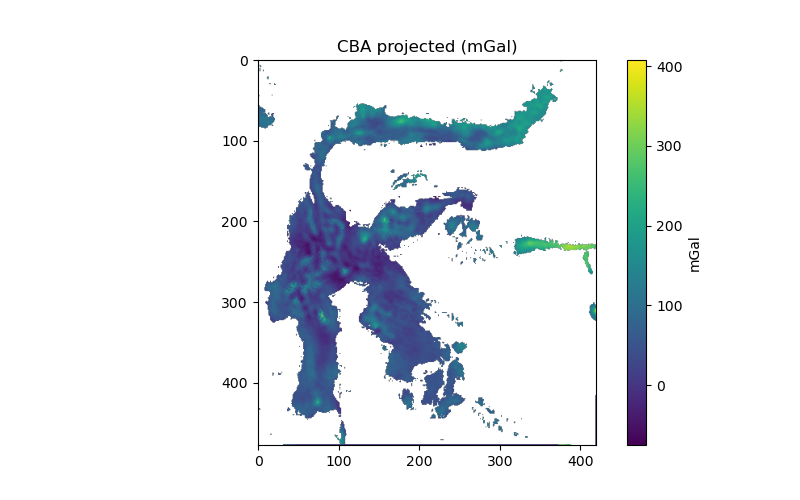

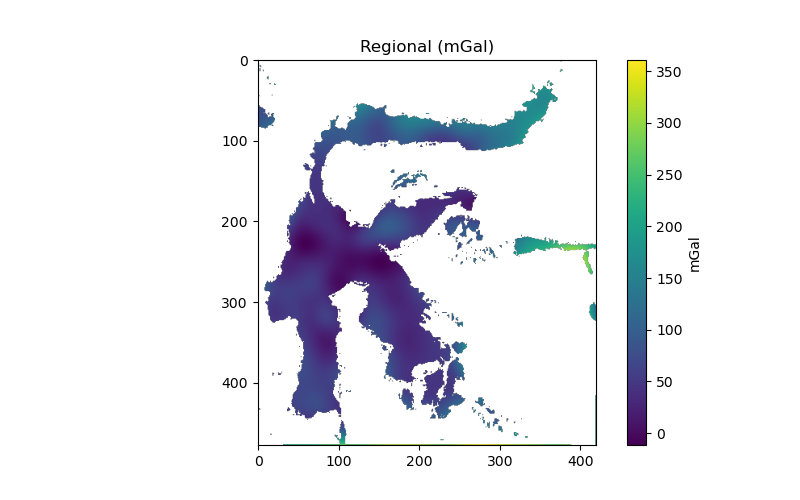

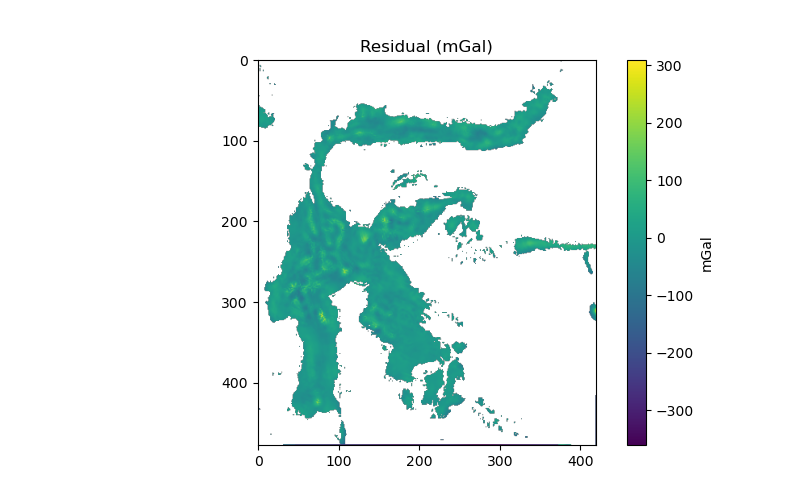

In [8]:
# =========================
# 6) Regional/Residual (Butterworth) from CBA
# =========================
import numpy as np
import rasterio
import matplotlib.pyplot as plt
from pyproj import CRS, Transformer
from rasterio.warp import reproject, Resampling, calculate_default_transform

# gunakan nodata global notebook
nodata = float(NODATA_OUT)

def laea_centered_crs(lon0, lat0):
    proj4 = f"+proj=laea +lat_0={lat0} +lon_0={lon0} +datum=WGS84 +units=m +no_defs"
    return CRS.from_proj4(proj4)

def butterworth_lowpass_fft(data, dx_m, dy_m, cutoff_km, order):
    z = data.copy().astype(float)
    nanmask = ~np.isfinite(z)
    meanv = np.nanmean(z)
    z[nanmask] = meanv

    ny, nx = z.shape
    fx = np.fft.fftfreq(nx, d=dx_m)  # cycles/m
    fy = np.fft.fftfreq(ny, d=dy_m)  # cycles/m
    kx, ky = np.meshgrid(fx, fy)
    k = np.sqrt(kx*kx + ky*ky)

    lam_c_m = float(cutoff_km) * 1000.0
    kc = 1.0 / lam_c_m

    H = 1.0 / np.sqrt(1.0 + (k / kc)**(2.0 * float(order)))
    F = np.fft.fft2(z)
    F_lp = F * H
    regional = np.real(np.fft.ifft2(F_lp))

    regional[nanmask] = np.nan
    residual = data - regional
    return regional, residual

cba_path = os.path.join(OUTDIR, "CBA_mGal.tif")
with rasterio.open(cba_path) as cba_ds:
    cba = cba_ds.read(1).astype("float32")
    if cba_ds.nodata is not None:
        cba = np.where(cba == cba_ds.nodata, np.nan, cba)

    if not DO_FILTER:
        print("[INFO] DO_FILTER=False; skip")
    else:
        # --- build LAEA centered on AOI ---
        cx = (cba_ds.bounds.left + cba_ds.bounds.right) / 2.0
        cy = (cba_ds.bounds.bottom + cba_ds.bounds.top) / 2.0
        to_wgs = Transformer.from_crs(cba_ds.crs, "EPSG:4326", always_xy=True)
        lon0, lat0 = to_wgs.transform(cx, cy)
        proj_crs = laea_centered_crs(lon0, lat0)

        px = float(FILTER_PX_M)

        dst_transform, dst_w, dst_h = calculate_default_transform(
            cba_ds.crs, proj_crs, cba_ds.width, cba_ds.height, *cba_ds.bounds, resolution=px
        )

        # --- reproject CBA to projected grid ---
        cba_proj = np.empty((dst_h, dst_w), dtype=np.float32)
        reproject(
            source=cba,
            destination=cba_proj,
            src_transform=cba_ds.transform,
            src_crs=cba_ds.crs,
            dst_transform=dst_transform,
            dst_crs=proj_crs,
            resampling=Resampling.bilinear
        )

        # --- compute Butterworth regional/residual ---
        regional, residual = butterworth_lowpass_fft(
            cba_proj, dx_m=px, dy_m=px, cutoff_km=float(CUTOFF_KM), order=int(ORDER_N)
        )

        # --- prepare output profile ---
        profile = cba_ds.profile.copy()
        profile.update({
            "crs": proj_crs,
            "transform": dst_transform,
            "width": dst_w,
            "height": dst_h,
            "dtype": rasterio.float32,
            "count": 1,
            "nodata": nodata,
            "compress": "deflate"
        })

        def write_proj(name, arr):
            p = os.path.join(OUTDIR, name)
            with rasterio.open(p, "w", **profile) as out:
                out_arr = arr.astype(np.float32)
                out_arr = np.where(np.isfinite(out_arr), out_arr, nodata).astype(np.float32)
                out.write(out_arr, 1)
            print("[WRITE]", p)

        # --- always write projected + regional + residual ---
        write_proj("CBA_projected_mGal.tif", cba_proj)
        write_proj("Regional_mGal.tif", regional)
        write_proj("Residual_mGal.tif", residual)

        # --- land mask on projected grid (from DEM) for landonly outputs/plots ---
        land_mask_proj = None
        if EXPORT_LANDONLY or MASK_SEA_FOR_PLOTS:
            with rasterio.open(DEM_TIF) as dds:
                dem_src = dds.read(1).astype("float32")
                if dds.nodata is not None:
                    dem_src = np.where(dem_src == dds.nodata, np.nan, dem_src)

                dem_proj = np.empty((dst_h, dst_w), dtype=np.float32)
                reproject(
                    source=dem_src,
                    destination=dem_proj,
                    src_transform=dds.transform,
                    src_crs=dds.crs,
                    dst_transform=dst_transform,
                    dst_crs=proj_crs,
                    resampling=Resampling.bilinear
                )

            land_mask_proj = np.isfinite(dem_proj) & (dem_proj >= float(SEA_LEVEL_M))

        # --- landonly outputs ---
        if EXPORT_LANDONLY and (land_mask_proj is not None):
            cba_proj_land = np.where(land_mask_proj, cba_proj, np.nan)
            regional_land = np.where(land_mask_proj, regional, np.nan)
            residual_land = np.where(land_mask_proj, residual, np.nan)

            write_proj("CBA_projected_mGal_landonly.tif", cba_proj_land)
            write_proj("Regional_mGal_landonly.tif", regional_land)
            write_proj("Residual_mGal_landonly.tif", residual_land)

        # --- plots (optionally land-only) ---
        if MASK_SEA_FOR_PLOTS and (land_mask_proj is not None):
            cba_show = np.where(land_mask_proj, cba_proj, np.nan)
            reg_show = np.where(land_mask_proj, regional, np.nan)
            res_show = np.where(land_mask_proj, residual, np.nan)
        else:
            cba_show, reg_show, res_show = cba_proj, regional, residual

        for name, arr in [("CBA projected (mGal)", cba_show),
                          ("Regional (mGal)", reg_show),
                          ("Residual (mGal)", res_show)]:
            plt.figure(figsize=(8,5))
            plt.title(name)
            plt.imshow(arr)
            plt.colorbar(label="mGal")
            plt.show()

## Catatan penting (satu pulau)

- Agar TC “stabil”, pastikan gravity AOI kamu mencakup **buffer** di sekitar Sulawesi (laut di sekeliling).  
  Kalau AOI terlalu “mekar pas batas pantai”, FFT bisa lebih banyak artefak edge.  
  Solusi yang sudah diterapkan di notebook: **padding + apodization**.

- `TC_MODE="paper"` cocok untuk replikasi paper sederhana (sering menganggap satu ρ untuk seluruh topografi).  
  Jika AOI kamu banyak laut/bathymetry, coba `TC_MODE="marine"` (eksperimental) dan bandingkan.

- Untuk menjawab “model struktur bawah permukaan”: gunakan **Residual** sebagai input profil/transek dan lakukan 2D forward modelling/inversi.


# (Tujuan 3) Model Struktur Bawah Permukaan — Profil Residual + Forward Modelling 2D

Bagian ini menuntaskan tujuan (3) dengan cara:
1) Mengambil **profil** dari peta **Residual (mGal)**  
2) Membuat **model struktur bawah permukaan 2D** (penampang) berbasis **bodies persegi panjang** dengan **kontras densitas** Δρ  
3) Menghitung respon gravitasi model (mGal) dan membandingkannya dengan profil residual (observasi)

## Asumsi & Unit
- Sistem koordinat pemodelan: **x** sepanjang profil (meter / km), **z** kedalaman positif ke bawah (meter / km).
- **Residual**: mGal  
- **Δρ**: kg/m³ (ingat: 1 g/cm³ = 1000 kg/m³)
- Model 2D mengasumsikan body memanjang tak hingga tegak lurus profil (asumsi 2D).

## Rumus forward modelling 2D (numerik, diskret)
Untuk elemen sel (dx·dz) pada kedalaman z (m) dan jarak horizontal r dari titik observasi:
\[
dg_z = 2G\,\Delta\rho\,(dx\,dz)\,\frac{z}{(x-x_c)^2+z^2}
\]
Total:
\[
g_z(x)=\sum dg_z
\]
Konversi:
\[
1\,\text{m/s}^2 = 10^5\,\text{mGal}
\]


Residual raster: (478, 420)
CRS: PROJCS["unknown",GEOGCS["WGS 84",DATUM["WGS_1984",SPHEROID["WGS 84",6378137,298.257223563,AUTHORITY["EPSG","7030"]],AUTHORITY["EPSG","6326"]],PRIMEM["Greenwich",0],UNIT["degree",0.0174532925199433,AUTHORITY["EPSG","9122"]],AUTHORITY["EPSG","4326"]],PROJECTION["Lambert_Azimuthal_Equal_Area"],PARAMETER["latitude_of_center",-1.9833333335],PARAMETER["longitude_of_center",122.3833333335],PARAMETER["false_easting",0],PARAMETER["false_northing",0],UNIT["metre",1],AXIS["Easting",EAST],AXIS["Northing",NORTH]]
Bounds: BoundingBox(left=-419310.17411695345, bottom=-478796.8917524267, right=420689.82588304655, top=477203.1082475733)


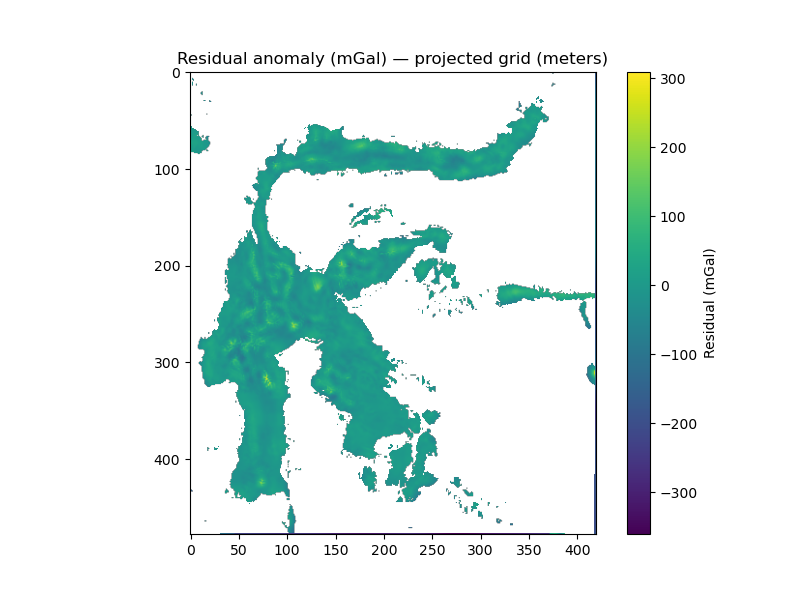

PILIH GARIS PROFIL:
A) Interaktif (klik 2 titik):
   - Jalankan: %matplotlib widget  (atau %matplotlib notebook)
   - Set INTERACTIVE=True pada sel berikutnya, lalu klik 2 titik di peta.
B) Manual:
   - Isi P0_X, P0_Y, P1_X, P1_Y (meter) di sel berikutnya.



In [9]:
# =========================
# 7) Load Residual raster (projected) and pick a profile line
# =========================
import os
import numpy as np
import rasterio
import matplotlib.pyplot as plt

RESIDUAL_TIF_FULL = os.path.join(OUTDIR, "Residual_mGal.tif")
RESIDUAL_TIF_LAND = os.path.join(OUTDIR, "Residual_mGal_landonly.tif")
RESIDUAL_TIF = RESIDUAL_TIF_LAND if os.path.exists(RESIDUAL_TIF_LAND) else RESIDUAL_TIF_FULL  # projected residual from Butterworth step
if not os.path.exists(RESIDUAL_TIF):
    raise FileNotFoundError(
        f"Residual raster not found: {RESIDUAL_TIF}\n"
        "Run the filter cell first (Regional/Residual)."
    )

with rasterio.open(RESIDUAL_TIF) as rds:
    residual = rds.read(1).astype("float32")
    if rds.nodata is not None:
        residual = np.where(residual == rds.nodata, np.nan, residual)

    print("Residual raster:", residual.shape)
    print("CRS:", rds.crs)
    print("Bounds:", rds.bounds)

    plt.figure(figsize=(8,6))
    plt.title("Residual anomaly (mGal) — projected grid (meters)")
    plt.imshow(residual)
    plt.colorbar(label="Residual (mGal)")
    plt.show()

print('''PILIH GARIS PROFIL:
A) Interaktif (klik 2 titik):
   - Jalankan: %matplotlib widget  (atau %matplotlib notebook)
   - Set INTERACTIVE=True pada sel berikutnya, lalu klik 2 titik di peta.
B) Manual:
   - Isi P0_X, P0_Y, P1_X, P1_Y (meter) di sel berikutnya.
''')

In [10]:
# =========================
# 8) Define profile endpoints (meters, projected CRS)
# =========================
# Option A (interactive): set INTERACTIVE=True and click 2 points
INTERACTIVE = False

# Option B (manual): fill these if INTERACTIVE=False
# Coordinates are in the projected CRS of Residual_mGal.tif (meters)
P0_X, P0_Y = 31.9, 294.8
P1_X, P1_Y = 121.9, 217.1

with rasterio.open(RESIDUAL_TIF) as rds:
    residual = rds.read(1).astype("float32")
    if rds.nodata is not None:
        residual = np.where(residual == rds.nodata, np.nan, residual)

    if INTERACTIVE:
        try:
            from rasterio.transform import xy as txy
            plt.figure(figsize=(8,6))
            plt.title("Click 2 points for profile endpoints")
            extent = (rds.bounds.left, rds.bounds.right, rds.bounds.bottom, rds.bounds.top)
            plt.imshow(residual, extent=extent, origin='upper')
            plt.xlabel('X (m)')
            plt.ylabel('Y (m)')
            plt.colorbar(label="Residual (mGal)")
            pts = plt.ginput(2, timeout=0)
            plt.close()

            (x0, y0), (x1, y1) = pts
            P0_X, P0_Y = float(x0), float(y0)
            P1_X, P1_Y = float(x1), float(y1)
            print("Picked endpoints (m):")
            print("P0:", P0_X, P0_Y)
            print("P1:", P1_X, P1_Y)
        except Exception as e:
            raise RuntimeError(f"Interactive selection failed: {e}")

if any(v is None for v in [P0_X, P0_Y, P1_X, P1_Y]):
    raise ValueError("Please set P0_X, P0_Y, P1_X, P1_Y (meters) or enable INTERACTIVE=True.")

print("Profile endpoints set (meters):")
print("P0:", P0_X, P0_Y)
print("P1:", P1_X, P1_Y)

Profile endpoints set (meters):
P0: 31.9 294.8
P1: 121.9 217.1


Residual CRS: PROJCS["unknown",GEOGCS["WGS 84",DATUM["WGS_1984",SPHEROID["WGS 84",6378137,298.257223563,AUTHORITY["EPSG","7030"]],AUTHORITY["EPSG","6326"]],PRIMEM["Greenwich",0],UNIT["degree",0.0174532925199433,AUTHORITY["EPSG","9122"]],AUTHORITY["EPSG","4326"]],PROJECTION["Lambert_Azimuthal_Equal_Area"],PARAMETER["latitude_of_center",-1.9833333335],PARAMETER["longitude_of_center",122.3833333335],PARAMETER["false_easting",0],PARAMETER["false_northing",0],UNIT["metre",1],AXIS["Easting",EAST],AXIS["Northing",NORTH]]
Residual bounds: BoundingBox(left=-419310.17411695345, bottom=-478796.8917524267, right=420689.82588304655, top=477203.1082475733)
P0 map: (-354740.92477427266, -113239.62636768412) inside? True
P1 map: (-17490.35296388907, 98581.92943786677) inside? True
Profile length: 398.25 km | samples: 201 | step ~ 2.00 km
OK fraction (inside raster): 100.0%
Finite fraction (has values): 100.0%


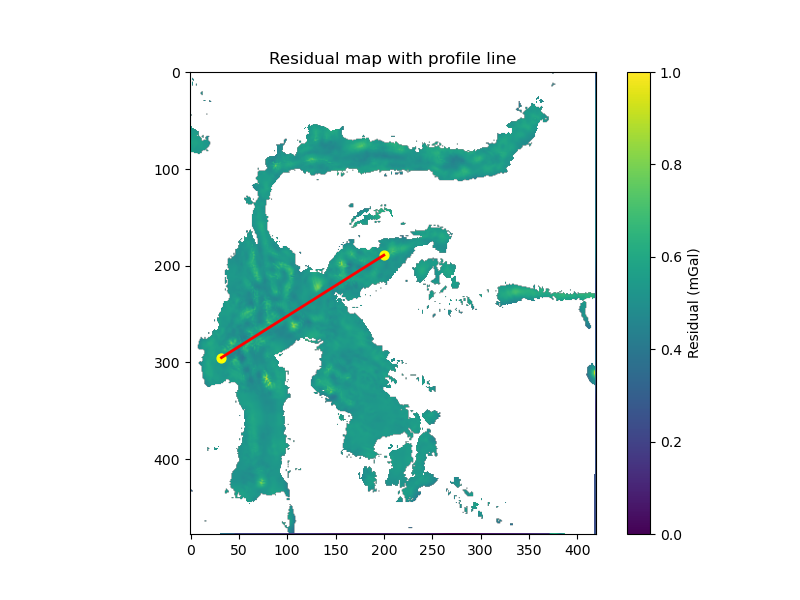

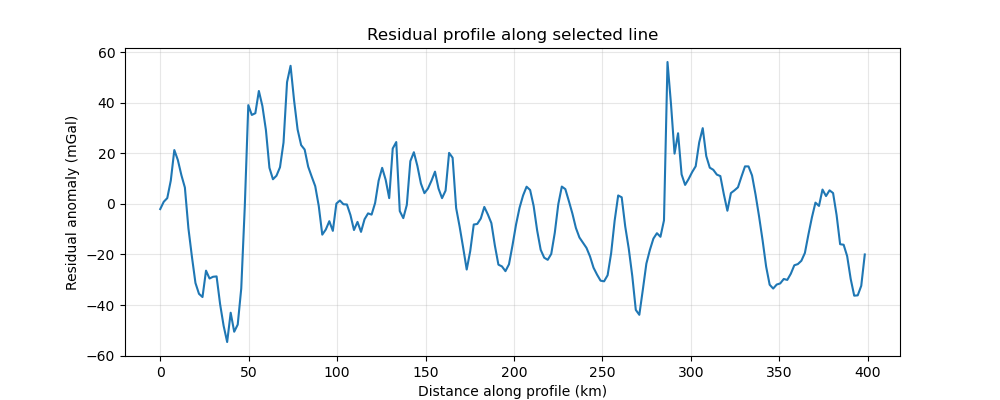

[CSV] saved: output\profile_residual_points.csv
[JSON] saved: output\profile_residual_meta.json


In [11]:
# =========================
# 9) Extract residual profile (bilinear) + Export CSV points (location + residual)
#    Robust: CRS-safe endpoints (lon/lat), bounds/valid diagnostics, optional snapping
# =========================
import os
import json
import numpy as np
import pandas as pd
import rasterio
import matplotlib.pyplot as plt
from affine import Affine
from pyproj import Transformer

# --- settings ---
PROFILE_STEP_M = 2000  # sampling step along profile (meters, because residual is projected meters)
PROFILE_PREFIX = "profile_residual"

# --- endpoints ---
# Recommended: use lon/lat (EPSG:4326), then convert to residual CRS automatically.
USE_LONLAT_ENDPOINTS = True

# Edit these endpoints (lon/lat in degrees) so the line stays on land (Sulawesi).
P0_LON, P0_LAT = 119.192002, -3.003965
P1_LON, P1_LAT = 122.226191, -1.091780

# If you want to provide endpoints directly in residual CRS, set USE_LONLAT_ENDPOINTS=False and fill these:
P0_X, P0_Y = None, None
P1_X, P1_Y = None, None


def bilinear_sample(arr, transform: Affine, xs, ys):
    """Return sampled values, ok-mask, and floating row/col indices."""
    inv = ~transform
    cols, rows = inv * (xs, ys)
    cols = np.asarray(cols, dtype=float)
    rows = np.asarray(rows, dtype=float)

    c0 = np.floor(cols).astype(int)
    r0 = np.floor(rows).astype(int)
    c1 = c0 + 1
    r1 = r0 + 1

    h, w = arr.shape
    ok = (c0 >= 0) & (r0 >= 0) & (c1 < w) & (r1 < h)

    out = np.full(cols.shape, np.nan, dtype=float)
    if not np.any(ok):
        return out, ok, rows, cols

    dc = cols[ok] - c0[ok]
    dr = rows[ok] - r0[ok]

    v00 = arr[r0[ok], c0[ok]]
    v10 = arr[r0[ok], c1[ok]]
    v01 = arr[r1[ok], c0[ok]]
    v11 = arr[r1[ok], c1[ok]]

    out[ok] = (v00*(1-dc)*(1-dr) + v10*dc*(1-dr) + v01*(1-dc)*dr + v11*dc*dr)
    return out, ok, rows, cols


def snap_to_nearest_finite(arr, row0, col0, max_radius_pix=60):
    """
    If endpoint lands on NaN (e.g., land-only mask), snap to nearest finite pixel.
    Returns (row, col, snapped_bool).
    """
    h, w = arr.shape
    r0 = int(np.clip(row0, 0, h-1))
    c0 = int(np.clip(col0, 0, w-1))
    if np.isfinite(arr[r0, c0]):
        return r0, c0, False

    for rad in range(1, max_radius_pix+1):
        rmin = max(0, r0-rad); rmax = min(h-1, r0+rad)
        cmin = max(0, c0-rad); cmax = min(w-1, c0+rad)
        window = arr[rmin:rmax+1, cmin:cmax+1]
        if np.isfinite(window).any():
            rr, cc = np.where(np.isfinite(window))
            # choose closest
            rr = rr + rmin
            cc = cc + cmin
            d2 = (rr-r0)**2 + (cc-c0)**2
            k = int(np.argmin(d2))
            return int(rr[k]), int(cc[k]), True

    return r0, c0, False


# ---- open residual raster ----
with rasterio.open(RESIDUAL_TIF) as rds:
    residual = rds.read(1).astype("float32")

    # robust nodata handling
    if rds.nodata is not None:
        residual = np.where(residual == rds.nodata, np.nan, residual)
    else:
        # fallback: common nodata such as -9999
        residual = np.where(residual <= -1e4, np.nan, residual)

    # transform endpoints to residual CRS if needed
    if USE_LONLAT_ENDPOINTS:
        if rds.crs is None:
            raise ValueError("Residual raster has no CRS; cannot convert lon/lat -> map.")
        tf_fwd = Transformer.from_crs("EPSG:4326", rds.crs, always_xy=True)
        P0_X, P0_Y = tf_fwd.transform(P0_LON, P0_LAT)
        P1_X, P1_Y = tf_fwd.transform(P1_LON, P1_LAT)
    else:
        if any(v is None for v in [P0_X, P0_Y, P1_X, P1_Y]):
            raise ValueError("Fill P0_X,P0_Y,P1_X,P1_Y if USE_LONLAT_ENDPOINTS=False")

    # endpoint bounds check
    b = rds.bounds
    inside0 = (b.left <= P0_X <= b.right) and (b.bottom <= P0_Y <= b.top)
    inside1 = (b.left <= P1_X <= b.right) and (b.bottom <= P1_Y <= b.top)
    print("Residual CRS:", rds.crs)
    print("Residual bounds:", rds.bounds)
    print("P0 map:", (P0_X, P0_Y), "inside?", inside0)
    print("P1 map:", (P1_X, P1_Y), "inside?", inside1)
    if not (inside0 and inside1):
        raise ValueError("Endpoint(s) outside residual bounds. Check lon/lat endpoints or raster/clip extent.")

    # snap endpoints if they land on NaN
    r0, c0 = rds.index(P0_X, P0_Y)
    r1, c1 = rds.index(P1_X, P1_Y)
    r0s, c0s, snapped0 = snap_to_nearest_finite(residual, r0, c0, max_radius_pix=80)
    r1s, c1s, snapped1 = snap_to_nearest_finite(residual, r1, c1, max_radius_pix=80)

    if snapped0:
        P0_X, P0_Y = rasterio.transform.xy(rds.transform, r0s, c0s, offset="center")
        print("[SNAP] P0 moved to nearest finite pixel.")
    if snapped1:
        P1_X, P1_Y = rasterio.transform.xy(rds.transform, r1s, c1s, offset="center")
        print("[SNAP] P1 moved to nearest finite pixel.")

    # build sampling points
    dx = P1_X - P0_X
    dy = P1_Y - P0_Y
    length_m = float(np.hypot(dx, dy))
    n = max(2, int(np.ceil(length_m / float(PROFILE_STEP_M))) + 1)

    t = np.linspace(0, 1, n)
    xs_map = P0_X + t*dx
    ys_map = P0_Y + t*dy

    prof_mgal, ok, rows_f, cols_f = bilinear_sample(residual, rds.transform, xs_map, ys_map)

    dist_m = t * length_m
    dist_km = dist_m / 1000.0

    ok_frac = float(np.mean(ok))
    finite_frac = float(np.mean(np.isfinite(prof_mgal)))
    print(f"Profile length: {length_m/1000:.2f} km | samples: {n} | step ~ {PROFILE_STEP_M/1000:.2f} km")
    print(f"OK fraction (inside raster): {ok_frac*100:.1f}%")
    print(f"Finite fraction (has values): {finite_frac*100:.1f}%")
    if not np.isfinite(prof_mgal).any():
        raise ValueError("Profile values are all NaN. Choose endpoints that stay on land (or use non-landonly residual).")

    # lon/lat for each point (for CSV)
    lon = np.full_like(xs_map, np.nan, dtype=float)
    lat = np.full_like(ys_map, np.nan, dtype=float)
    p0_lonlat = None
    p1_lonlat = None
    if rds.crs is not None:
        tf_back = Transformer.from_crs(rds.crs, "EPSG:4326", always_xy=True)
        lon, lat = tf_back.transform(xs_map, ys_map)
        p0_lonlat = tf_back.transform(P0_X, P0_Y)
        p1_lonlat = tf_back.transform(P1_X, P1_Y)

    # quick overlay check
    rr0, cc0 = rds.index(P0_X, P0_Y)
    rr1, cc1 = rds.index(P1_X, P1_Y)
    plt.figure(figsize=(8,6))
    plt.title("Residual map with profile line")
    plt.imshow(residual)
    plt.plot([cc0, cc1], [rr0, rr1], "-r", lw=2)
    plt.scatter([cc0, cc1], [rr0, rr1], c="yellow", s=40)
    plt.colorbar(label="Residual (mGal)")
    plt.show()

# profile plot
plt.figure(figsize=(10,4))
plt.plot(dist_km, prof_mgal)
plt.title("Residual profile along selected line")
plt.xlabel("Distance along profile (km)")
plt.ylabel("Residual anomaly (mGal)")
plt.grid(True, alpha=0.3)
plt.show()

# store for modelling
OBS_X_M = dist_m.astype(float)        # meters along profile
OBS_G_MGAL = prof_mgal.astype(float)  # observed residual (mGal)

# export CSV points
points_csv = os.path.join(OUTDIR, f"{PROFILE_PREFIX}_points.csv")
df_points = pd.DataFrame({
    "dist_km": dist_km,
    "x_map": xs_map,
    "y_map": ys_map,
    "lon_deg": np.asarray(lon, dtype=float),
    "lat_deg": np.asarray(lat, dtype=float),
    "row_pix": rows_f,
    "col_pix": cols_f,
    "inside_raster": ok.astype(int),
    "residual_mGal": prof_mgal,
})
df_points.to_csv(points_csv, index=False)
print("[CSV] saved:", points_csv)

# meta json
meta_json = os.path.join(OUTDIR, f"{PROFILE_PREFIX}_meta.json")
with open(meta_json, "w", encoding="utf-8") as f:
    json.dump({
        "residual_tif": RESIDUAL_TIF,
        "profile_step_m": float(PROFILE_STEP_M),
        "crs": str(rds.crs) if rds.crs else "",
        "p0_map": [float(P0_X), float(P0_Y)],
        "p1_map": [float(P1_X), float(P1_Y)],
        "p0_lonlat": [float(p0_lonlat[0]), float(p0_lonlat[1])] if p0_lonlat else None,
        "p1_lonlat": [float(p1_lonlat[0]), float(p1_lonlat[1])] if p1_lonlat else None
    }, f, indent=2)
print("[JSON] saved:", meta_json)

Valid observed points: 201 / 201
RMSE = 45.521 mGal


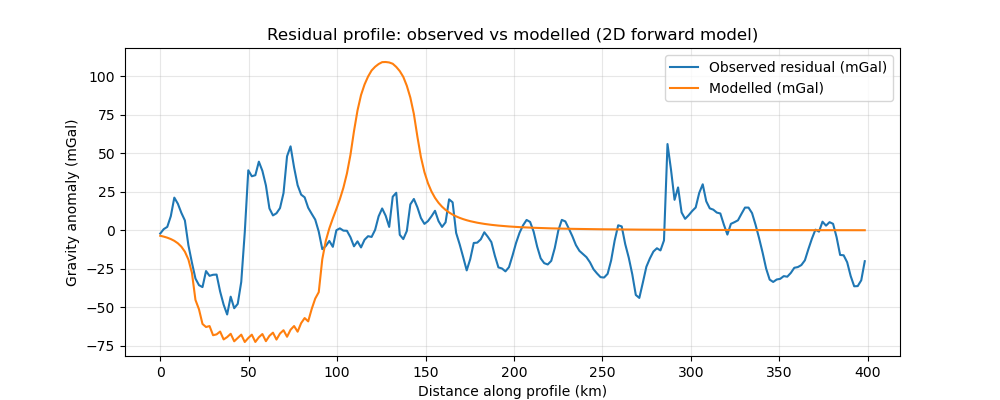

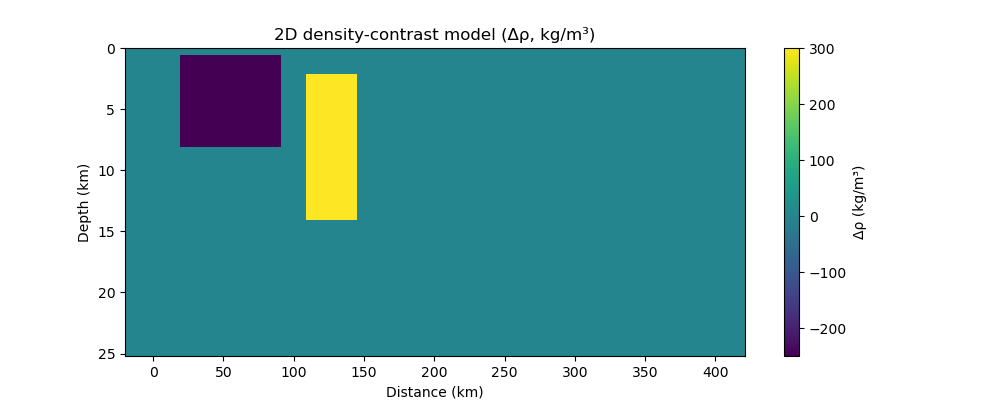

[CSV] saved: output\profile_residual_model_results.csv
[JSON] saved: output\profile_residual_model_config.json


In [12]:
# =========================
# 10) 2D Forward Modelling (rectangular bodies)
#     Robust: uses profile_points CSV, handles NaNs, exports modelled+misfit with locations
# =========================
import os
import json
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

G = 6.67430e-11        # m^3 kg^-1 s^-2
SI_TO_MGAL = 1e5       # 1 m/s^2 = 1e5 mGal

def forward_2d_rectangles(obs_x_m, bodies, dx_m=3000, dz_m=300, zmax_m=25000, xpad_m=20000):
    obs_x_m = np.asarray(obs_x_m, dtype=float)
    # drop non-finite x
    obs_x_m = obs_x_m[np.isfinite(obs_x_m)]
    if obs_x_m.size < 2:
        raise ValueError("Not enough profile x points for modelling.")

    xmin = float(np.nanmin(obs_x_m) - xpad_m)
    xmax = float(np.nanmax(obs_x_m) + xpad_m)

    x_edges = np.arange(xmin, xmax + dx_m, dx_m)
    z_edges = np.arange(0, zmax_m + dz_m, dz_m)
    x_cent = (x_edges[:-1] + x_edges[1:]) / 2
    z_cent = (z_edges[:-1] + z_edges[1:]) / 2

    Xc, Zc = np.meshgrid(x_cent, z_cent)  # (Nz, Nx)
    drho = np.zeros_like(Xc, dtype=float)

    for b in bodies:
        x1, x2 = float(b["x1_m"]), float(b["x2_m"])
        zt, zb = float(b["ztop_m"]), float(b["zbot_m"])
        d = float(b["drho_kgm3"])
        m = (Xc >= min(x1,x2)) & (Xc <= max(x1,x2)) & (Zc >= min(zt,zb)) & (Zc <= max(zt,zb))
        drho[m] += d

    cell_mass_per_len = drho * dx_m * dz_m  # kg/m (per unit strike length)

    xc = Xc.ravel()
    zc = Zc.ravel()
    mp = cell_mass_per_len.ravel()

    nz = np.abs(mp) > 0
    xc = xc[nz]; zc = zc[nz]; mp = mp[nz]

    g_si = np.zeros_like(obs_x_m, dtype=float)

    chunk = 512
    for i in range(0, obs_x_m.size, chunk):
        x0 = obs_x_m[i:i+chunk][:, None]
        ddx = x0 - xc[None, :]
        r2 = ddx*ddx + zc[None, :]*zc[None, :]
        g_si[i:i+chunk] = np.sum(2*G * mp[None, :] * zc[None, :] / r2, axis=1)

    return g_si * SI_TO_MGAL, (Xc, Zc, drho)

PROFILE_PREFIX = "profile_residual"
points_csv = os.path.join(OUTDIR, f"{PROFILE_PREFIX}_points.csv")
if not os.path.exists(points_csv):
    raise FileNotFoundError(f"Profile points CSV not found: {points_csv}. Run Cell #9 first.")

df_points = pd.read_csv(points_csv)

# observed arrays (meters, mGal)
obs_x_m_all = df_points["dist_km"].values.astype(float) * 1000.0
obs_g_all = df_points["residual_mGal"].values.astype(float)

valid = np.isfinite(obs_x_m_all) & np.isfinite(obs_g_all)
n_valid = int(valid.sum())
print("Valid observed points:", n_valid, "/", len(df_points))
if n_valid < 10:
    raise ValueError("Too few valid residual points for 2D modelling. Choose endpoints that stay on land / valid pixels.")

obs_x_m = obs_x_m_all[valid]
obs_g = obs_g_all[valid]

# -------------------------
# Define a starting model (EDIT THIS)
# Units:
# - x: meters along profile (0 at profile start)
# - z: meters depth (positive down)
# - Δρ: kg/m^3 (1 g/cm^3 = 1000 kg/m^3)
# -------------------------
BODIES = [
    dict(name="Basin",     x1_m=20000,  x2_m=90000,  ztop_m=500,  zbot_m=8000,  drho_kgm3=-250),
    dict(name="Intrusion", x1_m=110000, x2_m=145000, ztop_m=2000, zbot_m=14000, drho_kgm3=+300),
]

DX_M   = 3000   # m
DZ_M   = 300    # m
ZMAX_M = 25000  # m
XPAD_M = 20000  # m

g_model_mgal, (Xc, Zc, drho_grid) = forward_2d_rectangles(
    obs_x_m, BODIES, dx_m=DX_M, dz_m=DZ_M, zmax_m=ZMAX_M, xpad_m=XPAD_M
)

rmse = float(np.sqrt(np.mean((obs_g - g_model_mgal)**2)))
print(f"RMSE = {rmse:.3f} mGal")

# Plot observed vs modelled
plt.figure(figsize=(10,4))
plt.plot(obs_x_m/1000.0, obs_g, label="Observed residual (mGal)")
plt.plot(obs_x_m/1000.0, g_model_mgal, label="Modelled (mGal)")
plt.xlabel("Distance along profile (km)")
plt.ylabel("Gravity anomaly (mGal)")
plt.title("Residual profile: observed vs modelled (2D forward model)")
plt.grid(True, alpha=0.3)
plt.legend()
plt.show()

# Plot density model
plt.figure(figsize=(10,4))
plt.pcolormesh(Xc/1000.0, Zc/1000.0, drho_grid, shading="auto")
plt.gca().invert_yaxis()
plt.xlabel("Distance (km)")
plt.ylabel("Depth (km)")
plt.title("2D density-contrast model (Δρ, kg/m³)")
plt.colorbar(label="Δρ (kg/m³)")
plt.show()

# ---------- Export model results (keep locations; fill NaN for invalid rows) ----------
model_csv = os.path.join(OUTDIR, f"{PROFILE_PREFIX}_model_results.csv")
config_json = os.path.join(OUTDIR, f"{PROFILE_PREFIX}_model_config.json")

df_out = df_points.copy()
df_out["modelled_mGal"] = np.nan
df_out.loc[valid, "modelled_mGal"] = g_model_mgal
df_out["misfit_mGal"] = df_out["residual_mGal"] - df_out["modelled_mGal"]

df_out.to_csv(model_csv, index=False)
print("[CSV] saved:", model_csv)

with open(config_json, "w", encoding="utf-8") as f:
    json.dump({
        "dx_m": float(DX_M),
        "dz_m": float(DZ_M),
        "zmax_m": float(ZMAX_M),
        "xpad_m": float(XPAD_M),
        "bodies": BODIES,
        "rmse_mGal": rmse,
        "n_valid_points": n_valid
    }, f, indent=2)
print("[JSON] saved:", config_json)

## Checklist unit (untuk laporan/metode)
- FAA / BC / SBA / CBA / Regional / Residual: **mGal**
- DEM/topography/bathymetry h: **m**
- TC: **mGal**
- ρ (Parasnis): **g/cm³**
- Δρ (model): **kg/m³** (1 g/cm³ = 1000 kg/m³)
- Koordinat peta projected: **m**
- Jarak profil: **km**
- Kedalaman model: **km**
